# CNN & Transfer Learning




Gestern haben wir ein CNN entwickelt, welches Zahlen erkennen kann. Heute benutzen wir CNNs um 

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import sigmoid
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import roc_auc_score
plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

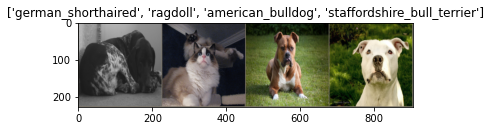

In [7]:
data_dir = '../data/images_animals' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [13]:
len(class_names)

37

In [47]:

model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)


In [48]:
for epoch in range(10):
    model_ft.train()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in dataloaders["train"]:
        optimizer_ft.zero_grad()
        output=model_ft(inputs)
        _ , preds = torch.max(output, 1)
        loss = criterion(output,targets)
        running_loss +=loss.item()
        loss.backward()
        optimizer_ft.step()
        running_corrects +=torch.sum(preds == targets.data)
        #running_auc += roc_auc_score(targets.float().detach().numpy(), pred.detach().numpy() )    
    epoch_loss = running_loss/len(dataloaders["train"])    
    epoch_auc = running_corrects.double() / dataset_sizes["train"]  
    print('Loss: {:.4f} AUC: {:.4f}'.format(
        epoch_loss, epoch_auc))
    model_ft.eval()
    running_loss = 0
    running_corrects = 0
    for inputs, targets in dataloaders["val"]:
        output=model_ft(inputs)
        _ , preds =torch.max(output, 1)
        loss = criterion(output,targets)
        running_loss +=loss.item()
        running_corrects +=torch.sum(preds == targets.data)
    epoch_auc = running_corrects.double() / dataset_sizes["val"]  
    epoch_loss = running_loss/len(dataloaders["val"])    
    print('Validation Loss: {:.4f} AUC: {:.4f}'.format(
        epoch_loss, epoch_auc))

Loss: 3.2266 AUC: 0.1914
Validation Loss: 2.6818 AUC: 0.4516
Loss: 2.3668 AUC: 0.5740
Validation Loss: 1.9627 AUC: 0.6947
Loss: 1.7977 AUC: 0.7450
Validation Loss: 1.5025 AUC: 0.7745
Loss: 1.4252 AUC: 0.8094
Validation Loss: 1.2091 AUC: 0.8186
Loss: 1.1825 AUC: 0.8387
Validation Loss: 1.0176 AUC: 0.8382
Loss: 1.0175 AUC: 0.8471
Validation Loss: 0.8973 AUC: 0.8524
Loss: 0.8901 AUC: 0.8598
Validation Loss: 0.7969 AUC: 0.8666
Loss: 0.8036 AUC: 0.8679
Validation Loss: 0.7318 AUC: 0.8653
Loss: 0.7340 AUC: 0.8794
Validation Loss: 0.6662 AUC: 0.8714
Loss: 0.6759 AUC: 0.8808
Validation Loss: 0.6281 AUC: 0.8741


In [62]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()


Epoch 0/24
----------
train Loss: 0.0087 Acc: 0.0312
val Loss: 0.5613 Acc: 0.0301

Epoch 1/24
----------
train Loss: 0.0061 Acc: 0.0312
val Loss: 0.5947 Acc: 0.0304

Epoch 2/24
----------


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)
plt.show()


In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = sigmoid(outputs)
                    loss = criterion(outputs, labels.float().unsqueeze(1))
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += roc_auc_score(labels.float().detach().numpy(), pred.detach().numpy() )


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects/ dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        